In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import glob
from keras import models, layers
import random
import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import model_from_json

In [ ]:
import zipfile
import os

!wget --no-check-certificate \
    "http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar" \
    -O "/tmp/imgs.rar"

--2021-11-12 04:23:22--  http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar
Resolving chaladze.com (chaladze.com)... 74.208.236.157, 2607:f1c0:100f:f000::25c
Connecting to chaladze.com (chaladze.com)|74.208.236.157|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138983573 (133M) [application/rar]
Saving to: ‘/tmp/imgs.rar’

/tmp/imgs.rar       100%[===================>] 132.54M  17.7MB/s    in 8.7s    

2021-11-12 04:23:31 (15.2 MB/s) - ‘/tmp/imgs.rar’ saved [138983573/138983573]



In [ ]:
!pip install patool
import patoolib
!mkdir /tmp/dataset
patoolib.extract_archive("/tmp/imgs.rar", outdir="/tmp/dataset/")

patool: Extracting /tmp/imgs.rar ...
patool: running /usr/bin/unrar x -- /tmp/imgs.rar
patool:     with cwd='/tmp/dataset/'
patool: ... /tmp/imgs.rar extracted to `/tmp/dataset/'.


'/tmp/dataset/'

In [ ]:
# !rm -r /tmp/dataset

In [ ]:
categories = ["berry", "bird", "dog", "flower", "other"]
# Location with subdirectories
for category in categories:
  my_path = "/tmp/dataset/Linnaeus 5 128X128/train/{}/".format(category)
  # Location to move images to
  main_dir = "/tmp/dataset/Linnaeus 5 128X128/train/"

  # Get List of all images
  files = glob.glob(my_path + '*.jpg', recursive=True)

  # For each image
  for file in files:
      # Get File name and extension
      filename = os.path.basename(file)
      # Copy the file with os.rename
      os.rename(
          file,
          main_dir + "{}_".format(category) + filename
      )
!rmdir "/tmp/dataset/Linnaeus 5 128X128/train/berry" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/bird" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/dog" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/flower" | rmdir "/tmp/dataset/Linnaeus 5 128X128/train/other"

In [ ]:
categories = ["berry", "bird", "dog", "flower", "other"]
# Location with subdirectories
for category in categories:
  my_path = "/tmp/dataset/Linnaeus 5 128X128/test/{}/".format(category)
  # Location to move images to
  main_dir = "/tmp/dataset/Linnaeus 5 128X128/test/"

  # Get List of all images
  files = glob.glob(my_path + '*.jpg', recursive=True)

  # For each image
  for file in files:
      # Get File name and extension
      filename = os.path.basename(file)
      # Copy the file with os.rename
      os.rename(
          file,
          main_dir + "{}_".format(category) + filename
      )
!rmdir "/tmp/dataset/Linnaeus 5 128X128/test/berry" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/bird" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/dog" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/flower" | rmdir "/tmp/dataset/Linnaeus 5 128X128/test/other"

In [ ]:
imdir = "/tmp/dataset/Linnaeus 5 128X128/train/"
tmdir = "/tmp/dataset/Linnaeus 5 128X128/test/"
train_files = []
test_files = []
[train_files.extend(glob.glob(imdir + '*'))]
x = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in train_files]
x_train = np.asarray(x, dtype=np.float32)
[test_files.extend(glob.glob(tmdir + '*'))]
x1 = [cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in test_files]
x_test = np.asarray(x1, dtype=np.float32)

In [ ]:
x_train.shape, x_test.shape

((6000, 128, 128), (2000, 128, 128))

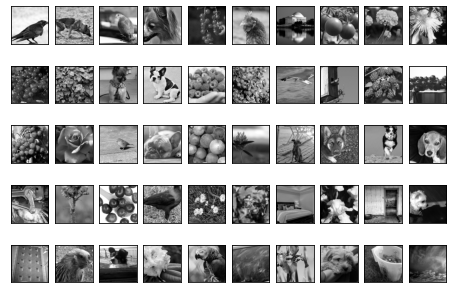

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 10) 
fig.tight_layout(pad=-1)
plt.gray()
a = 0 
for i in range(5): 
  for j in range(10): 
    axs[i, j].imshow(x_train[a]) 
    axs[i, j].xaxis.set_visible(False) 
    axs[i, j].yaxis.set_visible(False) 
    a = a + 1



In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(x_train.shape)
print(x_test.shape)

(6000, 128, 128, 1)
(2000, 128, 128, 1)


In [ ]:
def addGaussNoise(X_imgs):
  gaussian_noise_imgs = []
  row, col, ch = X_imgs[0].shape
  mean = 0
  for image in X_imgs:
    var = round(random.uniform(0.005, 0.05), 3)
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    gaussian_noise_imgs.append(noisy)
  gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
  return gaussian_noise_imgs
# noise_factor = 0.2
x_train_noisy = addGaussNoise(x_train) 
x_test_noisy = addGaussNoise(x_test)

In [ ]:
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.) 
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

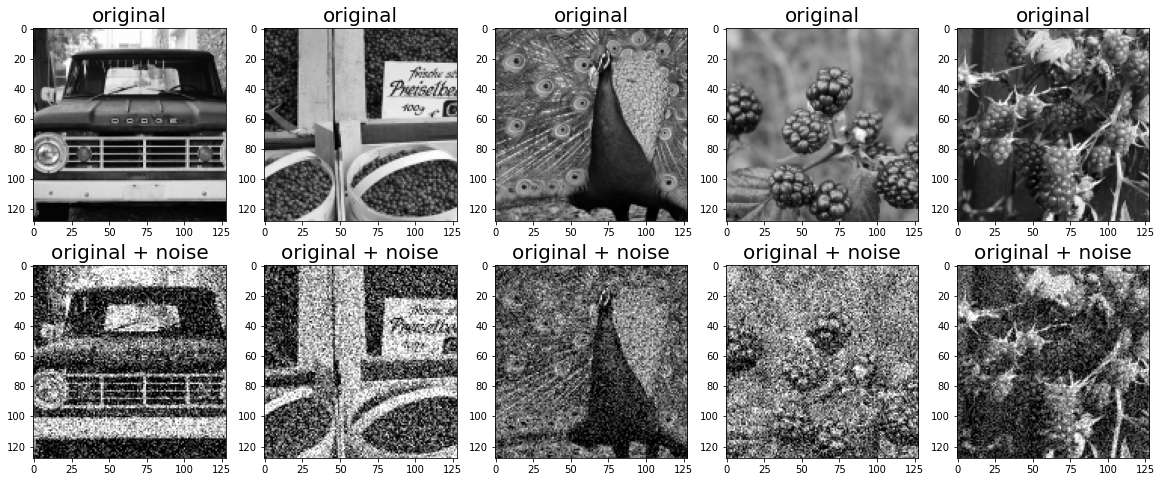

In [ ]:
n = 5
plt.figure(figsize=(20, 8))
plt.gray()
for i in range(n):
  ax = plt.subplot(2, n, i + 1) 
  plt.title("original", size=20) 
  plt.imshow(tf.squeeze(x_test[i])) 
  plt.gray() 
  bx = plt.subplot(2, n, n+ i + 1) 
  plt.title("original + noise", size=20) 
  plt.imshow(tf.squeeze(x_test_noisy[i])) 
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Input

class NoiseReducer(tf.keras.Model): 
  def __init__(self):

    super(NoiseReducer, self).__init__() 

    self.encoder = tf.keras.Sequential([ 
    Input(shape=(128, 128, 1)), 
    Conv2D(60, (6,6), activation='relu', padding='same', strides=2), 
    Conv2D(30, (6,6), activation='relu', padding='same', strides=2),
    Conv2D(15, (6,6), activation='relu', padding='same', strides=2)]) 
    
    self.decoder = tf.keras.Sequential([ 
    Conv2DTranspose(15, kernel_size=6, strides=2, activation='relu', padding='same'), 
    Conv2DTranspose(30, kernel_size=6, strides=2, activation='relu', padding='same'), 
    Conv2DTranspose(60, kernel_size=6, strides=2, activation='relu', padding='same'), 
    Conv2D(1, kernel_size=(6,6), activation='sigmoid', padding='same')]) 
  
  def call(self, x): 
    encoded = self.encoder(x) 
    decoded = self.decoder(encoded) 
    return decoded

In [ ]:
autoencoder = NoiseReducer()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.fit(x_train_noisy, 
                x_train, 
                epochs=50, 
                shuffle=True, 
                validation_data=(x_test_noisy, x_test))

Epoch 1/50
188/188 [==============================] - 32s 165ms/step - loss: 0.0229 - val_loss: 0.0108
Epoch 2/50
188/188 [==============================] - 30s 161ms/step - loss: 0.0092 - val_loss: 0.0074
Epoch 3/50
188/188 [==============================] - 30s 161ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 4/50
188/188 [==============================] - 30s 161ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 5/50
188/188 [==============================] - 30s 161ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 6/50
188/188 [==============================] - 30s 161ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 7/50
188/188 [==============================] - 30s 161ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 8/50
188/188 [==============================] - 30s 161ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 9/50
188/188 [==============================] - 30s 161ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 10/50
188/188 [==============================] - 30s 161ms/step - l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir -p /saved_model
# autoencoder.save('/saved_model/my_model')

INFO:tensorflow:Assets written to: /saved_model/my_model/assets


In [ ]:
# !zip -r /content/file.zip /saved_model
# from google.colab import files
# files.download("/content/file.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.index (deflated 69%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 93%)
  adding: saved_model/my_model/saved_model.pb (deflated 91%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# for i in x_test_noisy:
#   if i.shape == [2000, 64, 64, 30]:
#     print(i)

In [ ]:
# encoded_imgs=autoencoder.encoder(x_test_noisy).numpy()
# decoded_imgs=autoencoder.decoder(encoded_imgs)

In [ ]:
# n = 10 
# plt.figure(figsize=(20, 7))
# plt.gray()
# for i in range(n): 
#   # display original + noise 
#   bx = plt.subplot(3, n, i + 1) 
#   plt.title("original + noise") 
#   plt.imshow(tf.squeeze(x_test_noisy[i])) 
#   ax.get_xaxis().set_visible(False) 
#   ax.get_yaxis().set_visible(False) 
  
#   # display reconstruction 
#   cx = plt.subplot(3, n, i + n + 1) 
#   plt.title("reconstructed") 
#   plt.imshow(tf.squeeze(decoded_imgs[i])) 
#   bx.get_xaxis().set_visible(False) 
#   bx.get_yaxis().set_visible(False) 
  
#   # display original 
#   ax = plt.subplot(3, n, i + 2*n + 1) 
#   plt.title("original") 
#   plt.imshow(tf.squeeze(x_test[i])) 
#   ax.get_xaxis().set_visible(False) 
#   ax.get_yaxis().set_visible(False) 

# plt.show()

(128, 128)

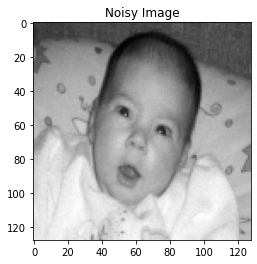

In [ ]:
import cv2
#Add kid.jpg into the filesystem env
test=cv2.imread("/content/kid.jpg",cv2.IMREAD_GRAYSCALE)
dim=(128,128)
test=cv2.resize(test, dim, interpolation = cv2.INTER_AREA)
test=test.astype('float32') / 255.
plt.title("Noisy Image") 
plt.imshow(test)
bx.get_xaxis().set_visible(False) 
bx.get_yaxis().set_visible(False)
test.shape

In [ ]:
test=np.expand_dims(test, axis=0)
test = test[..., tf.newaxis]

test.shape

(1, 128, 128, 1)

In [ ]:
e=autoencoder.encoder(test).numpy()
d=autoencoder.decoder(e)

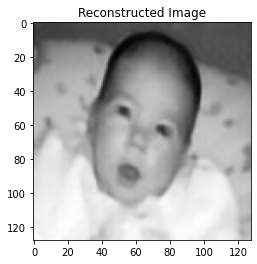

In [ ]:
plt.title("Reconstructed Image") 
plt.imshow(tf.squeeze(d[0]))
bx.get_xaxis().set_visible(False) 
bx.get_yaxis().set_visible(False) 